# Beam search 
Effectue une recherche par faisceau (beam search).

**Args:**
        
- start_state (object): L'état initial de la recherche.
- beam_width (int): La taille du faisceau (nombre de candidats à considérer).
- max_steps (int): Le nombre maximum d'étapes à effectuer.
- get_successors (function): la fonction de voisinage qui retourne les successeurs d'un états (voisins).
- evaluate (function): Une fonction qui prend un état en argument et retourne une valeur d'évaluation.

**Returns:**
- object: Le meilleur état trouvé par la beam search.


In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import heapq
from tqdm import tqdm
from typing import Callable,List,Tuple,Dict

cmap = plt.get_cmap('tab20') # type: ignore
State=Dict[any,int] # type: ignore

c:\Users\jw_be\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\jw_be\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\jw_be\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\jw_be\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Draw

In [2]:
def draw_graph(G:nx.Graph,state:State,label=False):
        map= [v for _,v in state.items()]
        u=np.unique(map)
        fixed_map=[np.where(u==i)[0][0] for i in map]
        node_cmap = [cmap(v) for v in fixed_map]
        
        pos = nx.spring_layout(G,seed=40)
        # add label too nodes
        if label:
            labels = {node:node for node in G.nodes()}
            nx.draw_networkx_labels(G, pos, labels, font_size=9)
            
        nx.draw(G, pos, node_size = 80, alpha = 0.8, node_color=node_cmap)
        plt.show()

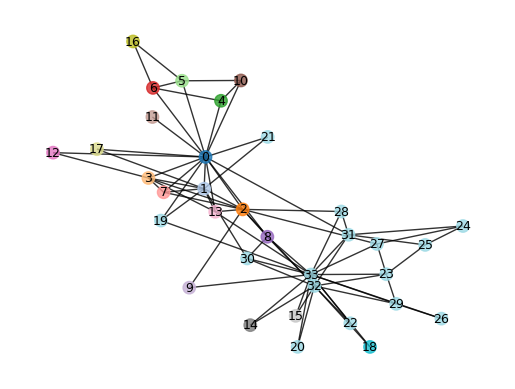

In [3]:
karate_club_graph:nx.Graph = nx.karate_club_graph() # type: ignore
initial_state = {node:i for i,node in enumerate(karate_club_graph.nodes())}
draw_graph(karate_club_graph,initial_state,label=True)

# Utils

In [4]:
def state_partitions(state:State)->List[State]:
    comm_dict = {}
    for node,comm in state.items():
        if comm in comm_dict:
            comm_dict[comm].add(node)
        else:
            comm_dict[comm] = {node}
    return list(comm_dict.values())

In [5]:
def partitions_state(partitions):
    state = {}
    for i,comm in enumerate(partitions):
        for node in comm:
            state[node] = i
    return state

# Initialisation

In [6]:
def init_alea(G:nx.Graph,nb_communities=None)->State:
    if nb_communities is None: nb_communities = len(G.nodes())
    if (nb_communities>len(G.nodes())): raise ValueError("nb_communities must be less than the number of nodes")

    state = {node:np.random.randint(0,nb_communities) for node in G.nodes()}
    return state

In [7]:
def init_greedy(G:nx.Graph)->State:
    partitions= nx.algorithms.community.greedy_modularity_communities(karate_club_graph)
    state=partitions_state(partitions)
    return state

# Fonction de fitness

In [8]:
def modularity(G, state):
    if (len(G.nodes)<=1 or G.number_of_edges()==0): 
        return 0
    partitions = state_partitions(state)
    return nx.algorithms.community.modularity(G, partitions)

In [9]:
modularity(karate_club_graph, initial_state)

-0.05110473941642772

In [10]:
def coverage(G,state):
    """
    how many nodes in a graph are assigned to a community.
    """
    partitions = state_partitions(state)
    return nx.algorithms.community.quality.partition_quality(G,partitions)[0]

In [11]:
coverage(karate_club_graph, initial_state)

0.0

In [12]:
def performance(G,state):
    """
    measure of how well a community detection algorithm partitions the nodes in 
    a graph into communities that reflect the underlying structure of the graph.
    """
    partitions = state_partitions(state)
    return nx.algorithms.community.quality.partition_quality(G,partitions)[1]

In [13]:
performance(karate_club_graph, initial_state)

0.8609625668449198

In [14]:
partitions = state_partitions(initial_state)
np.array(list(partitions))

array([{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12},
       {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23},
       {24}, {25}, {26}, {27}, {28}, {29}, {30}, {31}, {32}, {33}],
      dtype=object)

In [15]:
def cpm_modularity(G,state, gamma):
    """
    Calculates the modularity score of a graph using the Constant Potts Model (CPM).

    Parameters:
    - Q (nx.Graph): the graph to calculate the modularity score for.
    - gamma (float): the resolution parameter of the CPM.

    Returns:
    - modularity (float): the modularity score of the graph.
    """
    # Get the adjacency matrix of the graph
    A = nx.to_numpy_array(G)
    n = len(A)

    # Get the total weight of the graph
    m = np.sum(A) / 2

    # Calculate the degree of each node
    ki = np.sum(A, axis=1)

    # Calculate the modularity matrix
    B = A - gamma * np.outer(ki, ki) / (2 * m)

    # Calculate the modularity score
    
    partitions = state_partitions(state)
    ci = np.array(list(partitions))
    modularity = 0
    for c in ci:
        c=np.array(list(c))
        modularity += np.sum(B[np.ix_(c, c)])
    modularity /= (2 * m)

    return modularity
    

In [16]:
cpm_modularity(karate_club_graph,initial_state,0.5)

-0.02555236970821387

# Exploration du voisinage

In [17]:
def vertex_replacement(G:nx.Graph,state:State)->State:
    to_replace = np.random.choice(list(state.keys()))
    neighbors = list(G.neighbors(to_replace))
    replacement = np.random.choice(neighbors)
    new_state = state.copy()
    new_state[to_replace] = state[replacement]
    if modularity(G,new_state) > modularity(G,state):
        return new_state
        
    return state

In [18]:
new_state = vertex_replacement(karate_club_graph, initial_state)
print(new_state.values())
print(modularity(karate_club_graph, new_state))

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
-0.0442270572140702


In [19]:
def deplacement(G,state:State):
    # choose random community
    community = np.random.choice(list(set(state.values())))
    # choose random nodes in community
    community_nodes = [node for node in state.keys() if state[node] == community]
    number_of_nodes_to_move = np.random.randint(1,len(community_nodes)+1)
    nodes_to_move = np.random.choice(community_nodes, number_of_nodes_to_move, replace=False)
    # choose random community to move to
    new_community = np.random.choice(list(set(state.values()) - set([community])))
    new_state = state.copy()
    for node in nodes_to_move:
        new_state[node] = new_community
    if modularity(G,new_state) > modularity(G,state):
        return new_state
    return state

In [20]:
new_state = deplacement(karate_club_graph, initial_state)
print(new_state.values())
print(modularity(karate_club_graph, new_state))

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
-0.05110473941642772


In [21]:
def community_fusion(G,state:State):
    # choose random community
    community = np.random.choice(list(set(state.values())))
    # choose random community to fuse with
    new_community = np.random.choice(list(set(state.values()) - set([community])))
    new_state = state.copy()
    for node in new_state.keys():
        if new_state[node] == community:
            new_state[node] = new_community
    if modularity(G,new_state) > modularity(G,state):
        return new_state
    return state

In [22]:
new_state = community_fusion(karate_club_graph, initial_state)
print(new_state.values())
print(modularity(karate_club_graph, new_state))

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
-0.05110473941642772


In [23]:
def exhaustif_cross_mutation(G,history:List[Tuple[float,State]],N:int)->List[Tuple[float,State]]:
    if len(history) < 2:
        return history
    # choose random node
    node = np.random.choice(list(history[-1][1].keys()))
    # get nodes of the same community in every state
    neighbor_communities = []
    for _,state in history:
        comm=state[node]
        nodes_to_cross = [node for node in state.keys() if state[node] == comm]
        neighbor_communities.append(nodes_to_cross)

    states_cross=history.copy()
    for i,(_,state) in enumerate(history):
        for j,neighbor_community in enumerate(neighbor_communities):
            if(i==j):
                continue

            new_state = state.copy()
            for neighbor in neighbor_community:
                new_state[neighbor] = history[j][1][node]
            # check if new state already exists in history
            if(new_state in [state for _,state in states_cross]):
                continue
            mod=modularity(G,new_state)
            candidate = (mod, new_state)
            states_cross.append(candidate)
    
    states_cross=heapq.nlargest(N, states_cross,key=lambda x: x[0])

    return states_cross

In [24]:
history = []
heapq.heappush(history, (modularity(karate_club_graph, initial_state), initial_state))
heapq.heappush(history, (modularity(karate_club_graph, new_state), new_state))
history=heapq.nlargest(2, history)
print(history)

[(-0.05110473941642772, {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33}), (-0.05110473941642772, {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33})]


In [25]:
new_history = exhaustif_cross_mutation(karate_club_graph, history, 5)
print(new_history)

[(-0.05110473941642772, {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33}), (-0.05110473941642772, {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33})]


In [26]:
def cross_mutation(G:nx.Graph,history:List[Tuple[float,State]],N:int)->List[Tuple[float,State]]:
    if len(history) < 2:
        return history
    # choose random node
    states_cross=history.copy()

    node = np.random.choice(list(history[-1][1].keys()))
    # get two random states in history
    i,j = np.random.choice(range(len(history)), 2, replace=False)
    if i == j:
        return history
        
    state1=history[i][1]
    state2=history[j][1]
    neighbors_1 = [n for n in state1 if state1[n] == state1[node]]
    neighbors_2 = [n for n in state2 if state2[n] == state2[node]]

    new_C2=state2.copy()
    for n in neighbors_1:
        new_C2[n]=state1[node]

    if (not new_C2 in [state for _,state in states_cross]):
        mod=modularity(G,new_C2)
        candidate = (mod, new_C2)
        states_cross.append(candidate)
        states_cross=heapq.nlargest(N, states_cross,key=lambda x: x[0])

    new_C1=state1.copy()
    for n in neighbors_2:
        new_C1[n]=state2[node]

    if (not new_C1 in [state for _,state in states_cross]):
        mod=modularity(G,new_C1)
        candidate = (mod, new_C1)
        states_cross.append(candidate)
        states_cross=heapq.nlargest(N, states_cross,key=lambda x: x[0])

    return states_cross

In [27]:

mod=modularity(karate_club_graph,initial_state)
candidate = (mod, initial_state)
history:List[Tuple[float, State]]=[candidate]
new_state=initial_state
time=0
while(time<3000):
    new_state=vertex_replacement(karate_club_graph,new_state)
    if(not new_state in [state for _,state in history]):
        mod=modularity(karate_club_graph,new_state)
        candidate = (mod, new_state)
        history.append(candidate)
        history=heapq.nlargest(10, history)
    history = cross_mutation(karate_club_graph, history, 10)
    print(len(history),history[0][0])
    time+=1

2 -0.04902456850508799
3 -0.04185641198628211
4 -0.034435261707988975
5 -0.02223534041715859
6 -0.008592417683326773
7 -0.0034763216581398413
10 0.010307153164296028
10 0.01204999906298608
10 0.01204999906298608
10 0.01204999906298608
10 0.01204999906298608
10 0.01204999906298608
10 0.02557110998669439
10 0.02557110998669439
10 0.02557110998669439
10 0.042652873821704976
10 0.042652873821704976
10 0.04863102265699669
10 0.05571484792264013
10 0.07066959015010964
10 0.07376173609939846
10 0.08589606641554695
10 0.11113922152883193
10 0.11887895654129421
10 0.13126628061692994
10 0.15572234403403232
10 0.1715578793500871
10 0.1715578793500871
10 0.1715578793500871
10 0.1715578793500871
10 0.1715578793500871
10 0.1871591611851352
10 0.1871591611851352
10 0.1871591611851352
10 0.1871591611851352
10 0.21273964131106984
10 0.23719570472817222
10 0.23980060343696705
10 0.24843050167725494
10 0.24843050167725494
10 0.24843050167725494
10 0.24915200239875562
10 0.24915200239875562
10 0.24915200

In [28]:
class BeamSearch:
    
    G:nx.Graph
    beam:List[Tuple[float,State]]
    best_state:State
    get_successors:Callable[[nx.Graph,State,int],List[Tuple[float,State]]]
    evaluate:Callable[[nx.Graph,State],float]
    beam_width:int
    nb_successors:int

    def __init__(self, G:nx.Graph,start_state:State, get_successors:Callable[[nx.Graph,State,int],List[Tuple[float,State]]], evaluate:Callable[[nx.Graph,State],float], beam_width:int,nb_successors:int):
        """
        Effectue une recherche par faisceau (beam search).

        Args:
            start_state (object): L'état initial de la recherche.
            beam_width (int): La taille du faisceau (nombre de candidats à considérer).
            max_steps (int): Le nombre maximum d'étapes à effectuer.
            get_successors (function): la fonction de voisinage qui retourne les successeurs d'un états (voisins).
            evaluate (function): Une fonction qui prend un état en argument et retourne une valeur d'évaluation.

        Returns:
            object: Le meilleur état trouvé par la beam search.
        """
        self.G = G
        self.beam_width = beam_width
        self.get_successors = get_successors
        self.evaluate = evaluate
        self.beam = [(evaluate(G,start_state), start_state)]
        self.best_state = start_state
        self.nb_successors=nb_successors

    def search(self,max_steps:int):
        for _ in tqdm(range(max_steps)):
            candidates:List[Tuple[float,State]] = []  # Liste pour stocker les nouveaux candidats pour chaque étape
            candidates.extend(self.beam)
            for _, state in self.beam:
                successors = self.get_successors(self.G,state,self.nb_successors)
                # push successors in candidates
                candidates.extend(successors)
                candidates=heapq.nlargest(self.beam_width, candidates,key=lambda x: x[0]) 
            self.beam = heapq.nlargest(self.beam_width, candidates,key=lambda x: x[0])  # Sélectionne les meilleurs candidats, la beam c'est l'ensemble des noeuds accepté dans un niveau.

            if self.evaluate(self.G,self.best_state) < self.beam[0][0]:
                self.best_state = self.beam[0][1]  # Meilleur état trouvé
        
        return self.best_state


In [29]:
voisinage=[vertex_replacement,deplacement,community_fusion]

In [30]:
def get_successors(G:nx.Graph,state:State,N:int)->List[Tuple[float,State]]:
    successors:List[Tuple[float,State]] = []
    for _ in range(N):
        new_state=voisinage[np.random.randint(0,3)](G,state)
        mod=modularity(G,new_state)
        successor=(mod,new_state)
        successors.append(successor)
        
    successors=heapq.nlargest(N, successors,key=lambda x: x[0])
    successors=exhaustif_cross_mutation(G,successors,N)
    return successors

In [31]:
init_state=init_greedy(karate_club_graph)
modularity(karate_club_graph,init_state)

0.41096493693896297

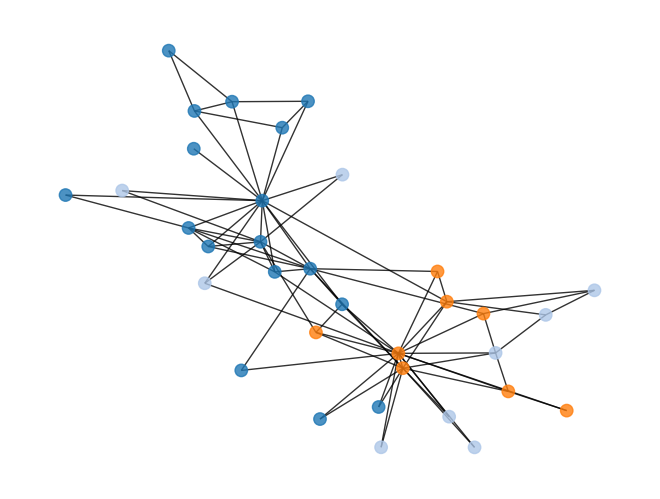

In [32]:
draw_graph(karate_club_graph,init_state)

In [33]:
beam=BeamSearch(karate_club_graph,start_state=init_state,get_successors=get_successors,evaluate=modularity,beam_width=10,nb_successors=30)

In [34]:
# result=beam.search(max_steps=300)

In [35]:
# modularity(karate_club_graph,result)

In [36]:
# draw_graph(karate_club_graph,result)

In [37]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.cluster import normalized_mutual_info_score
import numpy as np
# get karate club graph from nx
G = nx.karate_club_graph()

# Define adjacency matrix A for input graph
A = nx.adjacency_matrix(G).todense()
                

# Define number of communities to detect
k = 2

# Compute Laplacian matrix L
D = np.diag(np.sum(A, axis=1))
L = D - A

# Compute first k eigenvectors of L
eigenvalues, eigenvectors = np.linalg.eigh(L)
idx = eigenvalues.argsort()[:k]
U = eigenvectors[:,idx]

# Cluster nodes using k-means clustering
sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', assign_labels='kmeans')
labels = sc.fit_predict(U)
# numeric real labels
real_labels= np.array([G.nodes[i]['club']=='Mr. Hi' for i in range(len(G.nodes))]).astype(int)
normalized_mutual_info_score(real_labels.tolist(), labels.tolist())

0.8371694628777809

In [38]:
def get_neighbor_comms(G,state,comm):
    """
    Returns the neighboring communities of a given community.

    Args:
        G (networkx.Graph): The input graph.
        state (dict): A dictionary mapping each node to its corresponding community.
        comm (int): The community of interest.

    Returns:
        A list of neighboring communities.
    """
    # Initialize the list of neighboring communities
    neighbor_comms = []

    # Iterate over each node in the community of interest
    for node in [node for node in state.keys() if state[node] == comm]:
        # Iterate over each neighbor of the current node
        for neighbor in G.neighbors(node):
            # Add the neighbor's community to the list of neighboring communities if it is not already in the list
            if state[neighbor] not in neighbor_comms:
                neighbor_comms.append(state[neighbor])

    return neighbor_comms

In [39]:
def postprocess_refinement(G, states):
    """
    Re-merges any communities that have higher modularity when merged.

    Args:
        G (networkx.Graph): The input graph.
        states (dict): A dictionary mapping each node to its corresponding community.

    Returns:
        The updated community structure after post-processing.
    """
    # Initialize the community structure after post-processing
    postprocessed_states = states.copy()

    # Compute the initial modularity score
    initial_modularity = modularity(G, postprocessed_states)

    # Iterate over each community and try to merge it with its neighboring communities
    for comm in set(states.values()):
        # Compute the modularity score of the current community
        comm_nodes = [node for node in states.keys() if states[node] == comm]
        comm_modularity = modularity(G.subgraph(comm_nodes), {node: 0 for node in comm_nodes})

        # Iterate over each neighboring community of the current community
        for neighbor_comm in set(get_neighbor_comms(G,states, comm)):
            # Compute the modularity score of the merged community
            neighbor_nodes = [node for node in states.keys() if states[node] == neighbor_comm]
            merged_nodes=[]
            merged_nodes.extend(comm_nodes)
            merged_nodes.extend(neighbor_nodes)
            merged_modularity = modularity(G.subgraph(merged_nodes), {node: 1 for node in merged_nodes})

            # Merge the communities if the merged modularity is higher than the sum of individual modularity scores
            neighbor_modularity = modularity(G.subgraph(neighbor_nodes), {node: 1 for node in neighbor_nodes})
            if merged_modularity > comm_modularity + neighbor_modularity:
                # Update the community structure after post-processing
                for node in comm_nodes:
                    postprocessed_states[node] = neighbor_comm

    # Compute the final modularity score after post-processing
    final_modularity = modularity(G, postprocessed_states)

    # Return the community structure after post-processing if it results in a higher modularity score
    if final_modularity > initial_modularity:
        return postprocessed_states

    # Otherwise, return the original community structure
    return states


In [53]:
def get_successors(G:nx.Graph,state:State,N:int):
    k=2
    successors:List[Tuple[float,State]] = []
    partitions=state_partitions(state)
    for i in range(N):
        new_partition=[]    
        for community in partitions:
            if len(community) < 3:
                new_partition.append(community)
                continue

            # Compute subgraph induced by nodes in community
            subgraph = nx.subgraph(G, community)
            if (len(subgraph.edges()) < 1):
                new_partition.append(community)
                continue
            # Compute Laplacian matrix L for subgraph
            L = nx.laplacian_matrix(subgraph)
            # Compute first k eigenvectors of L
            eigenvalues, eigenvectors = np.linalg.eigh(L.todense())
            idx = eigenvalues.argsort()[:k]
            U = eigenvectors[:,idx]
            # Cluster nodes using k-means clustering
            sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', assign_labels='kmeans',n_neighbors=len(community)-1)
            labels = sc.fit_predict(U)
            # Add nodes to new communities based on cluster labels
            new_community_1 = set(np.array(list(community))[labels == 0])
            new_community_2 = set(np.array(list(community))[labels == 1])
            new_partition.append(new_community_1)
            new_partition.append(new_community_2)
        new_state=partitions_state(new_partition)
        new_state=postprocess_refinement(G,new_state)
        partitions=state_partitions(new_state)
        successors.append((modularity(G,new_state),new_state))
    return successors

In [54]:
init={node:0 for node in karate_club_graph.nodes()}
beam=BeamSearch(karate_club_graph,start_state=init,get_successors=get_successors,evaluate=modularity,beam_width=5,nb_successors=5)

In [55]:
result=beam.search(max_steps=10)

 60%|██████    | 6/10 [00:16<00:12,  3.06s/it]

In [51]:
modularity(karate_club_graph,result)

0.3412136204343997

In [52]:
# nmi 
real_labels= np.array([karate_club_graph.nodes[i]['club']=='Mr. Hi' for i in range(len(karate_club_graph.nodes))]).astype(int)
normalized_mutual_info_score(real_labels.tolist(), list(result.values()))

0.34921641590290625